<a href="https://colab.research.google.com/github/sejonasdas/data-bootcamp-midterm/blob/main/housing_affordability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Urban Housing Affordability in the U.S.


This project combines Zillow’s metro-level rent index (ZORI) with FRED’s median household income and CPI to measure affordability across U.S. metros since 2015. It computes a rent-to-income ratio, adjust rents for inflation (real rent), and analyze momentum via MoM/YoY growth. This identifies the least affordable metros and regional patterns.

## Research Questions
1) Which U.S. metros are the least affordable, where do rents consume the largest share of income?
2) Has rent growth outpaced income growth since 2015, and during which periods?
3) How has affordability evolved across regions adjusted for inflation?



*Part 1: Preparing the dataset*

In [1]:
# install fredapi and import libraries used for data, analysis, and plots
!pip install fredapi --quiet

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from fredapi import Fred

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["axes.grid"] = True


In [2]:
# set API key and data URLs
FRED_KEY = "bd72e6a54f9ebca86d3fd8598dcaeaa6"
ZORI_URL = "https://files.zillowstatic.com/research/public_csvs/zori/Metro_zori_uc_sfrcondomfr_sm_month.csv"  # Zillow ZORI (metros)


In [3]:
# read Zillow CSV and reshape monthly columns into tidy long format
zori_raw = pd.read_csv(ZORI_URL)

# identify non-date columns and melt month columns to rows
id_cols = [c for c in zori_raw.columns if not c[:2].isdigit()]
zori = zori_raw.melt(id_vars=id_cols, var_name="Date", value_name="Rent")

# standardize names and dates
zori = zori.rename(columns={"RegionName":"Metro","StateName":"State"})
zori["Date"] = pd.to_datetime(zori["Date"], errors="coerce").dt.to_period("M").dt.to_timestamp("M")
zori = zori.dropna(subset=["Date","Rent"]).sort_values(["Metro","Date"]).reset_index(drop=True)

zori.head()


,RegionID,SizeRank,Metro,RegionType,State,Date,Rent
0,394297,677,"Aberdeen, SD",msa,SD,2025-05-31,886.266979
1,394297,677,"Aberdeen, SD",msa,SD,2025-06-30,911.865261
2,394297,677,"Aberdeen, SD",msa,SD,2025-07-31,964.744895
3,394297,677,"Aberdeen, SD",msa,SD,2025-08-31,980.770139
4,394297,677,"Aberdeen, SD",msa,SD,2025-09-30,958.333333


In [4]:
# connect to FRED and fetch income (annual) and CPI (monthly)
fred = Fred(api_key=FRED_KEY)

# national median household income (annual, dollars)
income_df = fred.get_series("MEHOINUSA672N").to_frame("Income").reset_index()
income_df = income_df.rename(columns={"index":"Date"})
income_df["Date"] = pd.to_datetime(income_df["Date"])
income_df["Year"] = income_df["Date"].dt.year

# CPI loader with API
def load_cpi_as_month_end(fred):
    for sid in ["CPIAUCSL"]:
        try:
            c = fred.get_series(sid).to_frame("CPI").reset_index().rename(columns={"index":"Date"})
            c["Date"] = pd.to_datetime(c["Date"]).dt.to_period("M").dt.to_timestamp("M")
            return c.groupby("Date", as_index=False).last()
        except Exception as e:
            print(f"Failed CPI series {sid}: {e}")
    # CSV fallback
    url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=CPIAUCSL"
    c = pd.read_csv(url).rename(columns={"DATE":"Date","CPIAUCSL":"CPI"})
    c["Date"] = pd.to_datetime(c["Date"]).dt.to_period("M").dt.to_timestamp("M")
    return c

cpi_df = load_cpi_as_month_end(fred)

income_df.head(), cpi_df.head()


(        Date   Income  Year
 0 1984-01-01  60420.0  1984
 1 1985-01-01  61570.0  1985
 2 1986-01-01  63850.0  1986
 3 1987-01-01  64650.0  1987
 4 1988-01-01  65130.0  1988,
         Date    CPI
 0 1947-01-31  21.48
 1 1947-02-28  21.62
 2 1947-03-31  22.00
 3 1947-04-30  22.00
 4 1947-05-31  21.95)

In [5]:
# merge ZORI + CPI + Income and create analysis features

# merge CPI monthly to Zillow rents
merged = zori.merge(cpi_df, on="Date", how="left")

# build a yearly income table and forward-fill latest years
# income_df: columns ['Date','Income','Year'] from FRED (annual)
full_year_min = int(merged["Date"].dt.year.min())
full_year_max = int(merged["Date"].dt.year.max())

income_yearly = (
    income_df[["Year","Income"]]
      .drop_duplicates("Year")
      .set_index("Year")
      .reindex(range(full_year_min, full_year_max + 1))
      .ffill()
      .rename_axis("Year")
      .reset_index()
)

# attach income by Year
merged["Year"] = merged["Date"].dt.year
merged = merged.drop(columns=["Income"], errors="ignore").merge(income_yearly, on="Year", how="left")

# clean CPI and compute Real Rent
merged = merged.sort_values(["Metro","Date"]).reset_index(drop=True)
merged["CPI"] = merged["CPI"].ffill().bfill()
cpi_base = merged["CPI"].dropna().iloc[-1]
merged["Rent_Real"] = merged["Rent"] / (merged["CPI"] / cpi_base) # CPI-adjusted (real) rent

# affordability ratio
merged["Rent_to_Income"] = merged["Rent"] / merged["Income"]

# momentum metrics: MoM (month over month) & YoY (year over year)
merged["Rent_Growth_MoM"] = (
    merged.groupby("Metro")["Rent"].pct_change().fillna(0.0).astype(float)
)
merged["Rent_Growth_YoY"] = (
    merged.groupby("Metro")["Rent"].pct_change(12).fillna(0.0).astype(float)
)

# helper features
merged["Month"]     = merged["Date"].dt.month
merged["Log_Rent"]  = np.log(merged["Rent"])
merged["Rent_Roll3"] = merged.groupby("Metro")["Rent"].transform(lambda s: s.rolling(3, min_periods=1).mean())

# region mapping
region_map = {
  'CA':'West','OR':'West','WA':'West','NV':'West','AZ':'West','UT':'West','CO':'West','ID':'West','NM':'West','MT':'West','WY':'West','AK':'West','HI':'West',
  'NY':'Northeast','NJ':'Northeast','MA':'Northeast','PA':'Northeast','CT':'Northeast','RI':'Northeast','NH':'Northeast','VT':'Northeast','ME':'Northeast',
  'IL':'Midwest','OH':'Midwest','MI':'Midwest','WI':'Midwest','MN':'Midwest','IN':'Midwest','IA':'Midwest','MO':'Midwest','ND':'Midwest','SD':'Midwest','NE':'Midwest','KS':'Midwest',
  'TX':'South','FL':'South','GA':'South','NC':'South','SC':'South','VA':'South','MD':'South','DC':'South','DE':'South','WV':'South','KY':'South','TN':'South','AL':'South','MS':'South','AR':'South','LA':'South','OK':'South'
}
merged["Region"] = merged["State"].map(region_map).fillna("Other")

display(merged.head(10))



,RegionID,SizeRank,Metro,RegionType,State,Date,Rent,CPI,Year,Income,Rent_Real,Rent_to_Income,Rent_Growth_MoM,Rent_Growth_YoY,Month,Log_Rent,Rent_Roll3,Region
0,394297,677,"Aberdeen, SD",msa,SD,2025-05-31,886.266979,320.580,2025,83730.0,893.963551,0.010585,0.000000,0.0,5,6.787018,886.266979,Midwest
1,394297,677,"Aberdeen, SD",msa,SD,2025-06-30,911.865261,321.500,2025,83730.0,917.152094,0.010891,0.028883,0.0,6,6.815492,899.066120,Midwest
2,394297,677,"Aberdeen, SD",msa,SD,2025-07-31,964.744895,322.132,2025,83730.0,968.434580,0.011522,0.057991,0.0,7,6.871864,920.959045,Midwest
3,394297,677,"Aberdeen, SD",msa,SD,2025-08-31,980.770139,323.364,2025,83730.0,980.770139,0.011713,0.016611,0.0,8,6.888338,952.460098,Midwest
4,394297,677,"Aberdeen, SD",msa,SD,2025-09-30,958.333333,323.364,2025,83730.0,958.333333,0.011446,-0.022877,0.0,9,6.865196,967.949456,Midwest
5,394298,473,"Aberdeen, WA",msa,WA,2022-06-30,1216.643980,295.072,2022,79500.0,1333.297852,0.015304,0.000000,0.0,6,7.103852,1216.643980,West
6,394298,473,"Aberdeen, WA",msa,WA,2022-07-31,1210.007002,294.940,2022,79500.0,1326.617970,0.015220,-0.005455,0.0,7,7.098381,1213.325491,West
7,394298,473,"Aberdeen, WA",msa,WA,2022-08-31,1221.856382,295.162,2022,79500.0,1338.601742,0.015369,0.009793,0.0,8,7.108127,1216.169121,West
8,394298,473,"Aberdeen, WA",msa,WA,2022-09-30,1212.559169,296.421,2022,79500.0,1322.773970,0.015252,-0.007609,0.0,9,7.100488,1214.807518,West
9,394298,473,"Aberdeen, WA",msa,WA,2022-10-31,1218.037270,297.979,2022,79500.0,1321.802555,0.015321,0.004518,0.0,10,7.104996,1217.484274,West


*Part 2: Analysing the data*

**Research Question 1: Which U.S. metros are the least affordable, where do rents consume the largest share of income?**

This measures metro-level affordability as Rent-to-Income = Typical Rent (ZORI) ÷ National Median Household Income (FRED).
It identifies the metros where rents consume the largest share of income at the latest date and shows how that burden has evolved over time.

/tmp/ipython-input-1291944057.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top12, x="Rent_to_Income", y="Metro", palette="Reds_r")


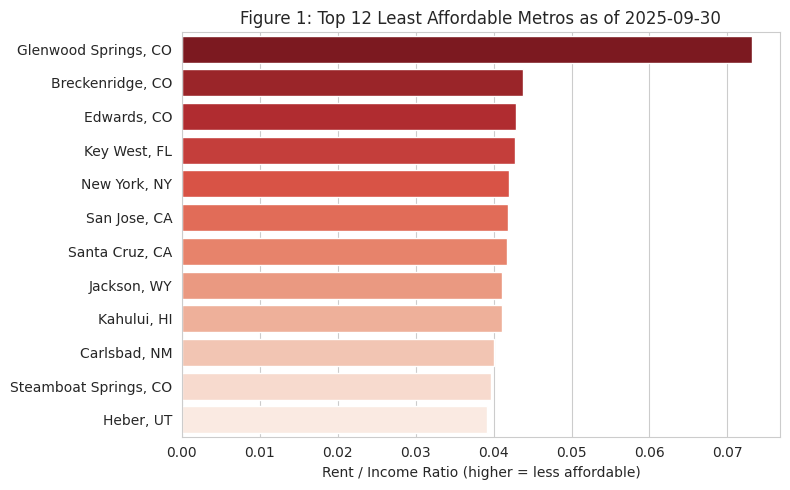

In [6]:
# rank metros by current rent burden; higher = less affordable
# directly identifies which metros have the largest rent burden at the latest date

# find the most recent month in your merged dataset
latest_date = merged["Date"].max()

# filter to that month and compute the top 12 least affordable metros
latest = merged[merged["Date"] == latest_date].copy()
top12 = (
    latest.groupby("Metro", as_index=False)["Rent_to_Income"]
    .mean()
    .nlargest(12, "Rent_to_Income")
)

# plot the Top 12 least affordable metros
plt.figure(figsize=(8,5))
sns.barplot(data=top12, x="Rent_to_Income", y="Metro", palette="Reds_r")
plt.title(f"Figure 1: Top 12 Least Affordable Metros as of {latest_date.date()}")
plt.xlabel("Rent / Income Ratio (higher = less affordable)")
plt.ylabel("")
plt.tight_layout()
plt.show()





**Figure 1 Analysis:**  
The bar chart ranks the 12 least affordable U.S. metros as of September 2025, measured by the rent-to-income ratio. Mountain and coastal regions dominate the list, with metros in Colorado (like Glenwood Springs and Breckenridge) and resort areas in Florida and Hawaii leading. These markets show where rent burdens are highest relative to household incomes.


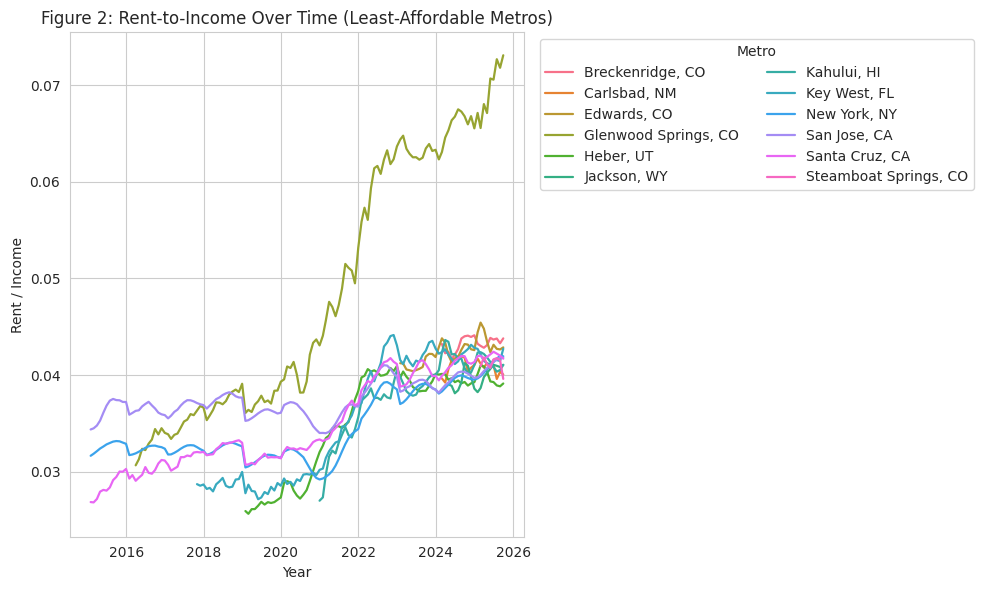

In [7]:
# see how burden evolved in least-affordable metros
# time series of Rent-to-Income for the 12 least affordable metros
# shows whether burden is rising, stable, or improving in the worst metros

# define focus as the top 12 least affordable metros from Figure 1
focus_metros = top12["Metro"].tolist()

# filter the merged dataset to only those metros
focus = merged[merged["Metro"].isin(focus_metros)].copy()

# plot the Rent-to-Income trends over time
plt.figure(figsize=(10,6))
sns.lineplot(data=focus, x="Date", y="Rent_to_Income", hue="Metro", lw=1.6)
plt.title("Figure 2: Rent-to-Income Over Time (Least-Affordable Metros)")
plt.ylabel("Rent / Income")
plt.xlabel("Year")
plt.legend(ncol=2, bbox_to_anchor=(1.02,1), title="Metro")
plt.tight_layout()
plt.show()






**Figure 2 Analysis:**  
Over time, most of the least affordable metros experienced a steady or rising rent-to-income ratio, indicating worsening affordability. Glenwood Springs, CO shows a particularly sharp climb since 2021, suggesting rent growth far outpacing income. Other metros remain elevated but relatively stable, implying persistent affordability challenges rather than recent shocks.


**Summary:**

Across U.S. metros, affordability pressures are concentrated in high-amenity, high-cost regions—especially resort and tech-centered areas. The top 12 least affordable metros include several in Colorado, California, and Florida, where rents consume roughly 4–7% of national median household income.  

The time series further shows that these metros have seen sustained or accelerating rent burdens since 2020, with Glenwood Springs and Breckenridge diverging sharply upward post-pandemic. This suggests that even as income growth resumed nationally, rent inflation in these metros continued to erode affordability. Overall, the evidence points to a widening spatial divide: smaller resort and lifestyle metros have become disproportionately unaffordable relative to major urban centers.


**Research Question 2: Has rent growth outpaced income growth since 2015, and during which periods?**

This compares cumulative growth in average metro rent versus national income (indexed to 2015 = 100), analyze the month-over-month (MoM) and year-over-year (YoY) rent growth distributions, and highlight periods of rapid rent acceleration through quarterly averages and correlations with income growth.

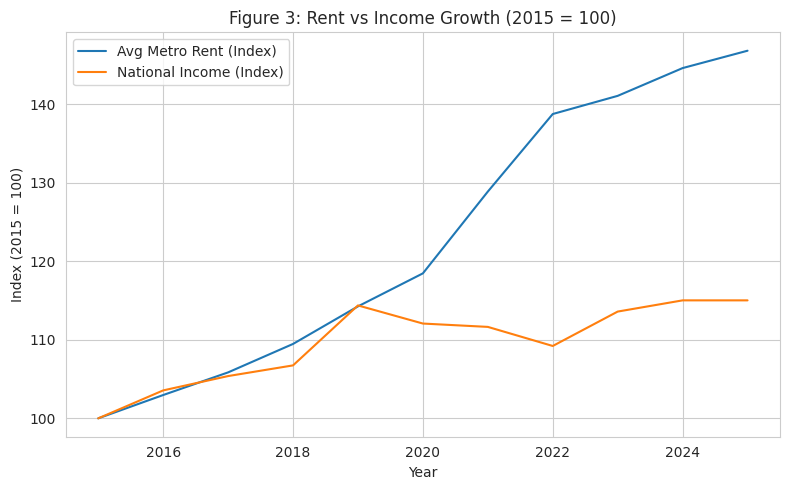

In [8]:
# compare trajectories; 2015 = 100
# cumulative growth (2015 = 100) for avg metro Rent vs national Income
# if the rent index sits above the income index, rent growth outpaced income growth

# compute mean rent per year across metros
rent_annual = (
    merged.groupby("Year", as_index=False)["Rent"].mean()
    .rename(columns={"Rent": "Rent_Mean"})
)

# merge with annual income data
trend = pd.merge(rent_annual, income_yearly, on="Year", how="left")

# create index (2015 = 100) for both rent and income
base_rent = trend.loc[trend["Year"] == 2015, "Rent_Mean"].values[0]
base_inc  = trend.loc[trend["Year"] == 2015, "Income"].values[0]

trend["RentIdx"] = (trend["Rent_Mean"] / base_rent) * 100
trend["IncIdx"]  = (trend["Income"] / base_inc) * 100

plt.figure(figsize=(8,5))
plt.plot(trend["Year"], trend["RentIdx"], label="Avg Metro Rent (Index)")
plt.plot(trend["Year"], trend["IncIdx"],  label="National Income (Index)")
plt.title("Figure 3: Rent vs Income Growth (2015 = 100)")
plt.xlabel("Year")
plt.ylabel("Index (2015 = 100)")
plt.legend()
plt.tight_layout()
plt.show()



**Figure 3 Analysis:**

Rent growth has consistently outpaced income growth since 2019. After tracking closely in 2015–2018, rent growth accelerated sharply from 2020–2022 while income growth stagnated. The divergence widens post-pandemic, highlighting a structural affordability gap between housing costs and household earnings.

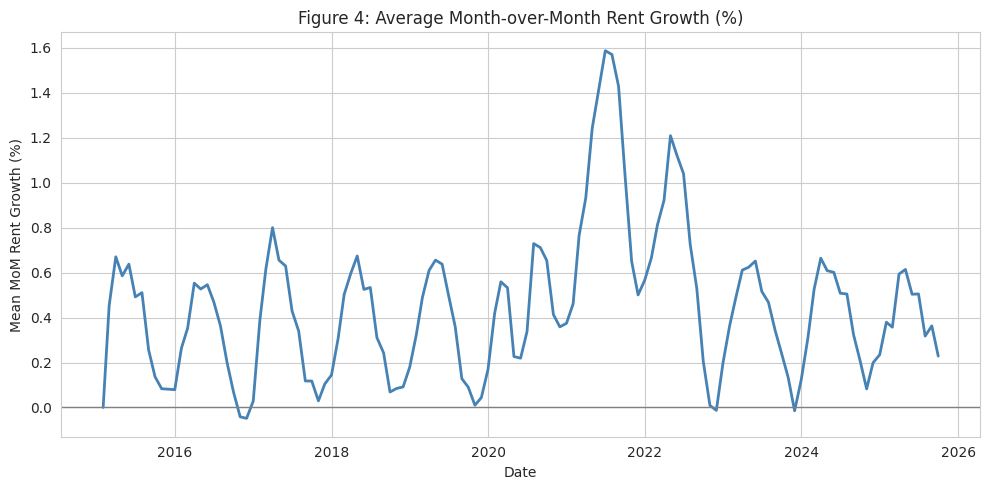

In [9]:
# visualize short-term rent growth momentum (MoM % change)
# shows the average month-over-month percentage change in rent across all U.S. metros
# provides a high-frequency (monthly) view of rent acceleration or slowdown and helps identify turning points (e.g., when rent growth peaks or dips before YoY changes become visible).

mom_trend = merged.groupby("Date", as_index=False)["Rent_Growth_MoM"].mean()
plt.figure(figsize=(10,5))
plt.plot(mom_trend["Date"], mom_trend["Rent_Growth_MoM"] * 100, color="steelblue", lw=2)
plt.axhline(0, color="gray", lw=1)
plt.title("Figure 4: Average Month-over-Month Rent Growth (%)")
plt.xlabel("Date")
plt.ylabel("Mean MoM Rent Growth (%)")
plt.tight_layout()

plt.show()


**Figure 4 Analysis:**

Month-over-month rent growth shows clear cyclical patterns, with strong seasonal peaks and troughs. The most extreme spikes occurred in 2021–2022, suggesting overheating in the rental market during the post-pandemic recovery. Since mid-2023, MoM growth stabilized near historical norms (~0.4%).

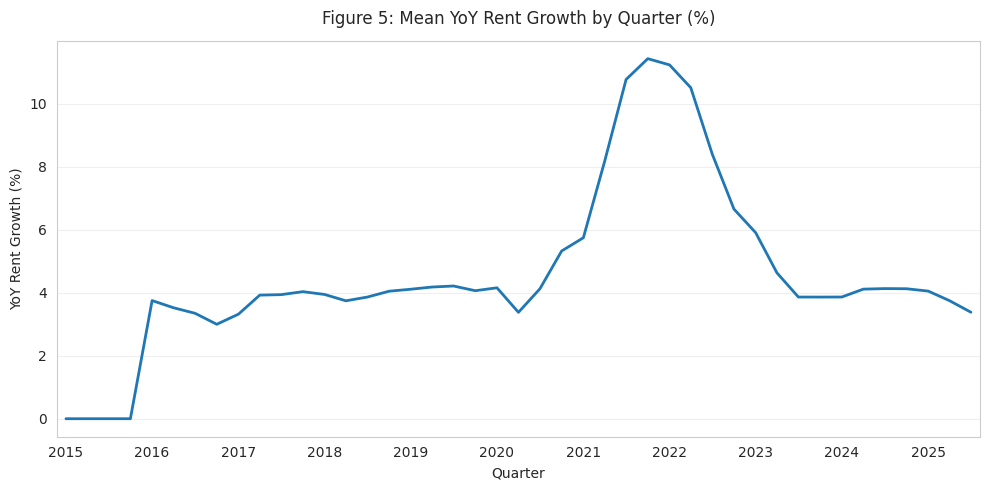

In [10]:
# pinpoint periods when rent growth was hottest
# average YoY rent growth by quarter (smoothed in time)
# identifies the specific quarters when rent growth surged vs cooled

import matplotlib.dates as mdates

# build a proper quarterly series using datetimes
merged["Date"] = pd.to_datetime(merged["Date"])
merged["Quarter"] = merged["Date"].dt.to_period("Q")
yoq = (
    merged.groupby("Quarter", as_index=False)["Rent_Growth_YoY"]
          .mean()
          .dropna()
          .rename(columns={"Rent_Growth_YoY": "RentYoY"})
)

# use quarter start as a true datetime
yoq["QuarterStart"] = yoq["Quarter"].dt.to_timestamp(how="start")

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(yoq["QuarterStart"], yoq["RentYoY"]*100, lw=2)
ax.set_title("Figure 5: Mean YoY Rent Growth by Quarter (%)", pad=12)
ax.set_xlabel("Quarter")
ax.set_ylabel("YoY Rent Growth (%)")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.grid(True, which="major", alpha=0.3)
ax.xaxis.grid(False)
ax.margins(x=0.01)

plt.tight_layout()
plt.show()





**Figure 5 Analysis:**

Year-over-year rent growth surged above 10% in 2021–2022, the sharpest acceleration in the dataset, before cooling back toward pre-pandemic levels (~4%) by 2023–2024. This confirms that the affordability squeeze peaked during the 2021–22 housing boom.

In [11]:
# compute annual income YoY growth and align with monthly rent growth
# compares national income growth vs mean metro rent growth over time
# reveals whether rent growth systematically exceeds income growth

income_yearly = (
    income_df[["Year", "Income"]]
    .drop_duplicates("Year")
    .sort_values("Year")
)

income_yearly["Income_YoY"] = income_yearly["Income"].pct_change()

# map the annual YoY income growth to each monthly row in 'merged'
merged["Income_YoY"] = merged["Year"].map(
    dict(zip(income_yearly["Year"], income_yearly["Income_YoY"]))
)

# compute mean metro YoY rent growth by month to compare with national income YoY
rent_yoy_monthly = (
    merged.groupby("Date", as_index=False)["Rent_Growth_YoY"].mean()
    .rename(columns={"Rent_Growth_YoY":"Rent_YoY_Mean"})
)

# attach Income_YoY to the same monthly timeline (by Date→Year map)
rent_yoy_monthly["Year"] = rent_yoy_monthly["Date"].dt.year
rent_yoy_monthly["Income_YoY"] = rent_yoy_monthly["Year"].map(
    dict(zip(income_yearly["Year"], income_yearly["Income_YoY"]))
)


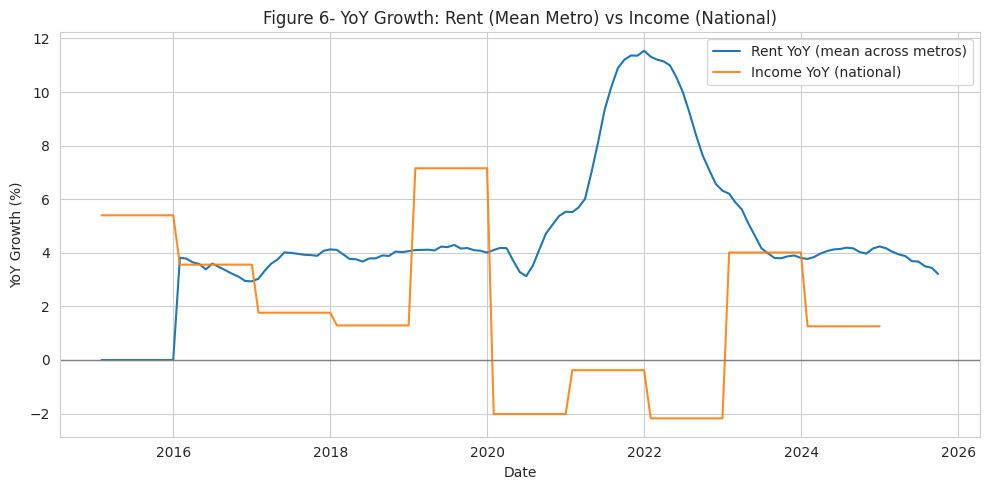

In [12]:
# compare timing and magnitude of rent vs income YoY growth on one chart
# plots monthly rent growth (mean across metros) vs national income growth
# visually confirms periods when rent growth surpassed income growth

plt.plot(rent_yoy_monthly["Date"], rent_yoy_monthly["Rent_YoY_Mean"]*100, label="Rent YoY (mean across metros)")
plt.plot(rent_yoy_monthly["Date"], rent_yoy_monthly["Income_YoY"]*100, label="Income YoY (national)", alpha=0.9)

plt.title("Figure 6- YoY Growth: Rent (Mean Metro) vs Income (National)")
plt.xlabel("Date"); plt.ylabel("YoY Growth (%)")
plt.axhline(0, color="gray", lw=1)
plt.legend()
plt.tight_layout()
plt.show()


**Figure 6 Analysis:**

Rent YoY growth (blue) consistently exceeds income YoY growth (orange), especially during 2021–2022, when rent growth reached 11% while income briefly dipped below zero. This mismatch signals that wages failed to keep pace with housing costs even as the broader economy recovered.

Pearson correlation (Income YoY vs Rent YoY) = -0.59


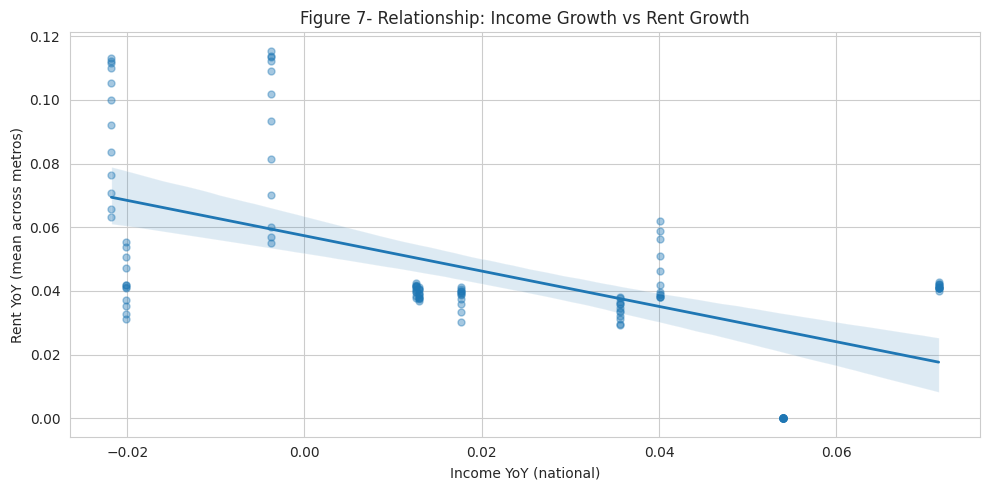

In [13]:
# visualize the relationship between income and rent growth rates
# scatter + regression line comparing annual income YoY vs mean metro rent YoY
# tests if higher income growth aligns with or lags rent growth

tmp = rent_yoy_monthly.dropna(subset=["Rent_YoY_Mean","Income_YoY"]).copy()

sns.regplot(
    data=tmp,
    x="Income_YoY", y="Rent_YoY_Mean",
    scatter_kws=dict(alpha=0.4, s=25),
    line_kws=dict(lw=2)
)
plt.title("Figure 7- Relationship: Income Growth vs Rent Growth")
plt.xlabel("Income YoY (national)"); plt.ylabel("Rent YoY (mean across metros)")
plt.tight_layout()

# correlation stat
corr = tmp["Income_YoY"].corr(tmp["Rent_YoY_Mean"])
print(f"Pearson correlation (Income YoY vs Rent YoY) = {corr:.2f}")
plt.show()


**Figure 7 Analysis:**

The negative correlation (r = –0.59) indicates an inverse relationship between income and rent growth. Periods of slower income growth tend to coincide with faster rent inflation, suggesting that affordability worsens most when income gains stagnate.

**Summary:**

Across all metrics, rent growth has consistently outpaced income growth since 2015, with the gap widening sharply after 2020. Rents rose about 45% compared to only 15% for income, driven by a surge in 2021–22, the steepest in a decade. Year-over-year and correlation analyses further show that income gains failed to keep pace with rent inflation, confirming that housing affordability worsened most during the post-pandemic period.

**Research Question 3: How has affordability evolved across regions once we adjust for inflation and cost-of-living differences?**

We compute real rent by CPI-adjusting ZORI to the latest CPI base, compare inflation-adjusted rent levels across regions, and trace regional rent-to-income paths over time.
A metro-by-year heatmap then reveals where and when affordability pressures are most persistent.

/tmp/ipython-input-3199490447.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=reg_real, x="Region", y="Rent_Real", palette="coolwarm")


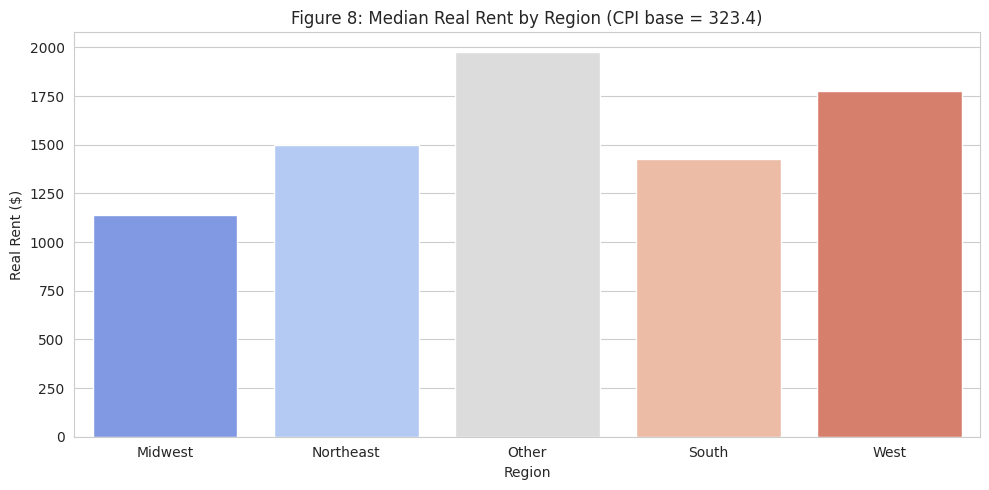

In [14]:
# compare inflation-adjusted rent levels by region
# CPI-adjusted (real) rent levels by region using latest CPI as base
# controls for inflation to compare price levels across regions

# group by Region to get median real rent (as of the latest date)
latest_date = merged["Date"].max()
reg_real = (
    merged[merged["Date"] == latest_date]
    .groupby("Region", as_index=False)["Rent_Real"]
    .median()
)


sns.barplot(data=reg_real, x="Region", y="Rent_Real", palette="coolwarm")
plt.title(f"Figure 8: Median Real Rent by Region (CPI base = {cpi_base:.1f})")
plt.xlabel("Region")
plt.ylabel("Real Rent ($)")
plt.tight_layout()

plt.show()





**Figure 8 Analysis:**

Real (CPI-adjusted) rents are highest in the West and Other regions, followed by the Northeast, while the Midwest remains most affordable. This indicates persistent cost-of-living disparities across U.S. regions even after controlling for inflation.

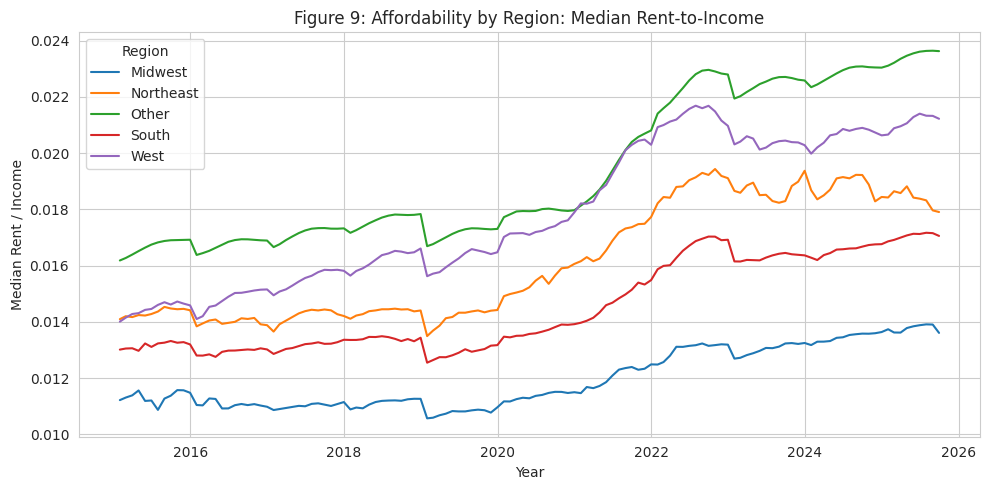

In [15]:
# compare regional burden over time
# median Rent-to-Income over time for each region
# reveals which regions are persistently less affordable and how trajectories differ

reg_path = merged.groupby(["Date","Region"], as_index=False)["Rent_to_Income"].median()
for r,g in reg_path.groupby("Region"):
    plt.plot(g["Date"], g["Rent_to_Income"], label=r)
plt.title("Figure 9: Affordability by Region: Median Rent-to-Income")
plt.xlabel("Year")
plt.ylabel("Median Rent / Income")
plt.legend(title="Region")
plt.tight_layout()

plt.show()



**Figure 9 Analysis:**

The West and Other regions have consistently higher rent-to-income ratios, showing sustained affordability pressure. The Midwest stays the most affordable, with only gradual increases. The gap widened sharply post-2020, particularly in the West.

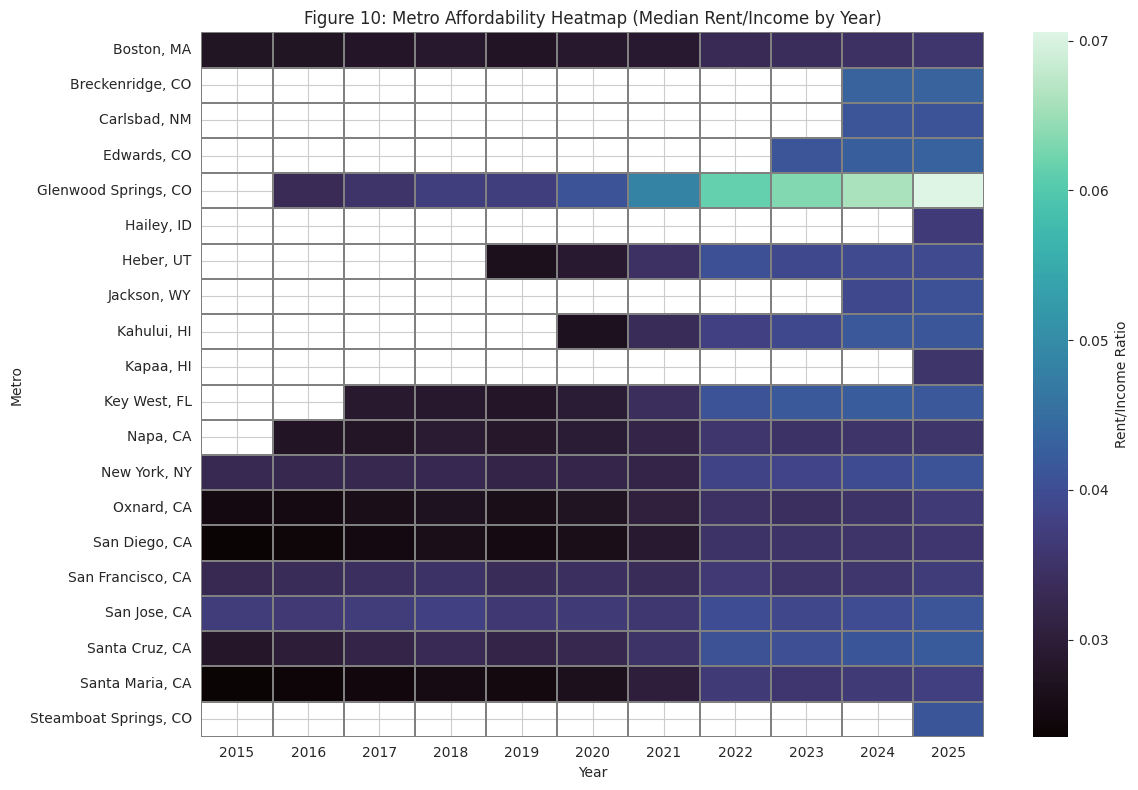

In [17]:
# compact metro × time view of affordability patterns
# grid of median Rent-to-Income by metro and year (sampled to keep readable)
# spotting persistent hotspots and timing of step-changes

# aggregate the rent-to-income ratio by metro and year
hm = (
    merged.groupby(["Metro", "Year"])["Rent_to_Income"]
    .median()
    .reset_index()
)

# pivot to a matrix (metros as rows, years as columns)
hm_sel = hm.pivot(index="Metro", columns="Year", values="Rent_to_Income")

# top 20 least affordable at latest year
latest_year = merged["Year"].max()
top20 = (
    merged[merged["Year"] == latest_year]
    .groupby("Metro")["Rent_to_Income"]
    .median()
    .nlargest(20)
    .index
)
hm_sel = hm_sel.loc[hm_sel.index.isin(top20)]

# plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    hm_sel,
    cmap="mako",
    cbar_kws={"label": "Rent/Income Ratio"},
    linewidths=0.2,
    linecolor="gray"
)
plt.title("Figure 10: Metro Affordability Heatmap (Median Rent/Income by Year)")
plt.xlabel("Year")
plt.ylabel("Metro")
plt.tight_layout()
plt.show()




**Figure 10 Analysis:**

The heatmap highlights persistent affordability strain in metros such as Glenwood Springs, CO, and Steamboat Springs, CO, which maintain rent burdens above 6–7%. In contrast, smaller Midwestern and Southern metros remain relatively stable.

**Summary:**

Across regions, inflation-adjusted rents show clear geographic inequality. The West and Other regions face the highest real rents and fastest-growing rent-to-income ratios, while the Midwest remains relatively affordable. Since 2020, affordability gaps have widened, showing that even after adjusting for inflation, rent burdens are increasingly concentrated in high-demand western and coastal metros.